In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import warnings
warnings.filterwarnings("ignore")

## The data

We start by downloading the data for both datasets

In [39]:
from problem import get_train_data

data_train, labels_train = get_train_data()

In [40]:
data_train.head()

,participants_site,participants_sex,participants_age,participants_dataset,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,...,fmri_basc064,fmri_basc122,fmri_basc197,fmri_craddock_scorr_mean,fmri_harvard_oxford_cort_prob_2mm,fmri_msdl,fmri_power_2011,fmri_motions,fmri_select,repetition_time
subject_id,,,,,,,,,,,,,,,,,,,,,
adhd700021,204,F,11.17,adhd200,1124,743,2886,1535,589,3731,...,data/fmri_adhd/basc064/adhd700021/run_1/adhd70...,data/fmri_adhd/basc122/adhd700021/run_1/adhd70...,data/fmri_adhd/basc197/adhd700021/run_1/adhd70...,data/fmri_adhd/craddock_scorr_mean/adhd700021/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd700021/run_1/adhd70002...,data/fmri_adhd/power_2011/adhd700021/run_1/adh...,data/fmri_adhd/motions/adhd700021/run_1/motion...,1,2.0
adhd242402,204,F,13.24,adhd200,1039,595,1966,1568,411,2769,...,data/fmri_adhd/basc064/adhd242402/run_1/adhd24...,data/fmri_adhd/basc122/adhd242402/run_1/adhd24...,data/fmri_adhd/basc197/adhd242402/run_1/adhd24...,data/fmri_adhd/craddock_scorr_mean/adhd242402/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd242402/run_1/adhd24240...,data/fmri_adhd/power_2011/adhd242402/run_1/adh...,data/fmri_adhd/motions/adhd242402/run_1/motion...,1,2.0
adhd972340,204,F,13.75,adhd200,601,492,1554,1345,455,2452,...,data/fmri_adhd/basc064/adhd972340/run_1/adhd97...,data/fmri_adhd/basc122/adhd972340/run_1/adhd97...,data/fmri_adhd/basc197/adhd972340/run_1/adhd97...,data/fmri_adhd/craddock_scorr_mean/adhd972340/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd972340/run_1/adhd97234...,data/fmri_adhd/power_2011/adhd972340/run_1/adh...,data/fmri_adhd/motions/adhd972340/run_1/motion...,1,2.0
adhd055645,204,F,11.18,adhd200,699,521,1773,1251,341,2628,...,data/fmri_adhd/basc064/adhd055645/run_1/adhd05...,data/fmri_adhd/basc122/adhd055645/run_1/adhd05...,data/fmri_adhd/basc197/adhd055645/run_1/adhd05...,data/fmri_adhd/craddock_scorr_mean/adhd055645/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd055645/run_1/adhd05564...,data/fmri_adhd/power_2011/adhd055645/run_1/adh...,data/fmri_adhd/motions/adhd055645/run_1/motion...,1,2.0
adhd436785,204,F,11.41,adhd200,799,605,2564,1688,419,2508,...,data/fmri_adhd/basc064/adhd436785/run_1/adhd43...,data/fmri_adhd/basc122/adhd436785/run_1/adhd43...,data/fmri_adhd/basc197/adhd436785/run_1/adhd43...,data/fmri_adhd/craddock_scorr_mean/adhd436785/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd436785/run_1/adhd43678...,data/fmri_adhd/power_2011/adhd436785/run_1/adh...,data/fmri_adhd/motions/adhd436785/run_1/motion...,1,2.0


Checking data for each dataset

In [41]:
data_train.participants_dataset.value_counts()

abide      1127
adhd200     506
Name: participants_dataset, dtype: int64

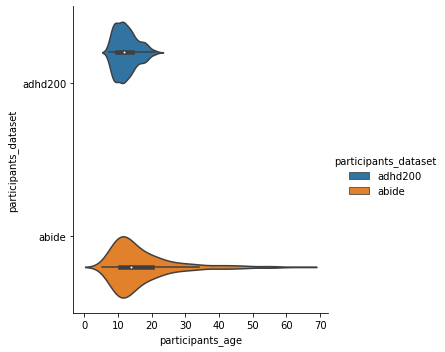

In [42]:
import seaborn as sns
sns.catplot(x="participants_age", y="participants_dataset", hue="participants_dataset",
            kind="violin", data=data_train)

Creating separated train datasets 

In [43]:
data_train_abide=data_train[data_train['participants_dataset']=='abide']
data_train_adhd=data_train[data_train['participants_dataset']=='adhd200']

Creating separeted train labels

In [44]:
print(labels_train)

[1 1 0 ... 0 1 0]


In [45]:
print('Number of subjects in the training tests: {}'.format(labels_train.size))

Number of subjects in the training tests: 1633


In [46]:
labels_train_abide=labels_train[506:1633]
labels_train_adhd=labels_train[0:506]

#### Participant features

In [47]:
data_train_participants = data_train[[col for col in data_train.columns if col.startswith('participants')]]
data_train_participants.head()

,participants_site,participants_sex,participants_age,participants_dataset
subject_id,,,,
adhd700021,204,F,11.17,adhd200
adhd242402,204,F,13.24,adhd200
adhd972340,204,F,13.75,adhd200
adhd055645,204,F,11.18,adhd200
adhd436785,204,F,11.41,adhd200


#### Structural MRI features

A set of structural features have been extracted for each subject: (i) normalized brain volume computed using subcortical segmentation of FreeSurfer and (ii) cortical thickness and area for right and left hemisphere of FreeSurfer.

In [48]:
data_train_anatomy = data_train[[col for col in data_train.columns if col.startswith('anatomy')]]
data_train_anatomy.head()

,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,anatomy_lh_inferiortemporal_area,anatomy_lh_isthmuscingulate_area,anatomy_lh_lateraloccipital_area,...,anatomy_SupraTentorialVolNotVentVox,anatomy_MaskVol,anatomy_BrainSegVol.to.eTIV,anatomy_MaskVol.to.eTIV,anatomy_lhSurfaceHoles,anatomy_rhSurfaceHoles,anatomy_SurfaceHoles,anatomy_EstimatedTotalIntraCranialVol,anatomy_eTIV,anatomy_select
subject_id,,,,,,,,,,,,,,,,,,,,,
adhd700021,1124,743,2886,1535,589,3731,4220,3491,890,4989,...,1034028,1544179,0.810540,1.055481,46,51,97,1.463009e+06,1.463009e+06,1
adhd242402,1039,595,1966,1568,411,2769,4235,2698,885,5246,...,942270,1413593,0.819411,1.071676,61,70,131,1.319049e+06,1.319049e+06,1
adhd972340,601,492,1554,1345,455,2452,3761,2273,837,3741,...,788484,1279934,0.769160,1.063212,91,61,152,1.203837e+06,1.203837e+06,1
adhd055645,699,521,1773,1251,341,2628,4026,2882,746,3951,...,823592,1303815,0.806114,1.079301,42,42,84,1.208018e+06,1.208018e+06,1
adhd436785,799,605,2564,1688,419,2508,5048,3616,1215,5496,...,1023783,1532056,0.843271,1.094796,59,81,140,1.399398e+06,1.399398e+06,1


Note that the column `anatomy_select` contain a label affected during a manual quality check (i.e. `0` and `3` reject, `1` accept, `2` accept with reserve). This column can be used during training to exclude noisy data for instance.

In [49]:
data_train_anatomy['anatomy_select'].head()

subject_id
adhd700021    1
adhd242402    1
adhd972340    1
adhd055645    1
adhd436785    1
Name: anatomy_select, dtype: int64

#### Functional MRI features

In [50]:
data_train_functional = data_train[[col for col in data_train.columns if col.startswith('fmri')]]
data_train_functional.head()

,fmri_basc064,fmri_basc122,fmri_basc197,fmri_craddock_scorr_mean,fmri_harvard_oxford_cort_prob_2mm,fmri_msdl,fmri_power_2011,fmri_motions,fmri_select
subject_id,,,,,,,,,
adhd700021,data/fmri_adhd/basc064/adhd700021/run_1/adhd70...,data/fmri_adhd/basc122/adhd700021/run_1/adhd70...,data/fmri_adhd/basc197/adhd700021/run_1/adhd70...,data/fmri_adhd/craddock_scorr_mean/adhd700021/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd700021/run_1/adhd70002...,data/fmri_adhd/power_2011/adhd700021/run_1/adh...,data/fmri_adhd/motions/adhd700021/run_1/motion...,1
adhd242402,data/fmri_adhd/basc064/adhd242402/run_1/adhd24...,data/fmri_adhd/basc122/adhd242402/run_1/adhd24...,data/fmri_adhd/basc197/adhd242402/run_1/adhd24...,data/fmri_adhd/craddock_scorr_mean/adhd242402/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd242402/run_1/adhd24240...,data/fmri_adhd/power_2011/adhd242402/run_1/adh...,data/fmri_adhd/motions/adhd242402/run_1/motion...,1
adhd972340,data/fmri_adhd/basc064/adhd972340/run_1/adhd97...,data/fmri_adhd/basc122/adhd972340/run_1/adhd97...,data/fmri_adhd/basc197/adhd972340/run_1/adhd97...,data/fmri_adhd/craddock_scorr_mean/adhd972340/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd972340/run_1/adhd97234...,data/fmri_adhd/power_2011/adhd972340/run_1/adh...,data/fmri_adhd/motions/adhd972340/run_1/motion...,1
adhd055645,data/fmri_adhd/basc064/adhd055645/run_1/adhd05...,data/fmri_adhd/basc122/adhd055645/run_1/adhd05...,data/fmri_adhd/basc197/adhd055645/run_1/adhd05...,data/fmri_adhd/craddock_scorr_mean/adhd055645/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd055645/run_1/adhd05564...,data/fmri_adhd/power_2011/adhd055645/run_1/adh...,data/fmri_adhd/motions/adhd055645/run_1/motion...,1
adhd436785,data/fmri_adhd/basc064/adhd436785/run_1/adhd43...,data/fmri_adhd/basc122/adhd436785/run_1/adhd43...,data/fmri_adhd/basc197/adhd436785/run_1/adhd43...,data/fmri_adhd/craddock_scorr_mean/adhd436785/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd436785/run_1/adhd43678...,data/fmri_adhd/power_2011/adhd436785/run_1/adh...,data/fmri_adhd/motions/adhd436785/run_1/motion...,1


Unlike the anatomical and participants data, the available data are filename to CSV files in which the time-series information are stored. We show in the next section how to read and extract meaningful information from those data.

Similarly to the anatomical data, the column `fmri_select` gives information about the manual quality check.

In [51]:
data_train_functional['fmri_select'].head()

subject_id
adhd700021    1
adhd242402    1
adhd972340    1
adhd055645    1
adhd436785    1
Name: fmri_select, dtype: int64

#### Testing data

The testing data can be loaded similarly as follows:

In [52]:
from problem import get_test_data

data_test, labels_test = get_test_data()

In [53]:
data_test.head()

,participants_site,participants_sex,participants_age,participants_dataset,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,...,fmri_basc064,fmri_basc122,fmri_basc197,fmri_craddock_scorr_mean,fmri_harvard_oxford_cort_prob_2mm,fmri_msdl,fmri_power_2011,fmri_motions,fmri_select,repetition_time
subject_id,,,,,,,,,,,,,,,,,,,,,
adhd317934,207,M,13.33,adhd200,1215,592,3205,2045,508,3996,...,data/fmri_adhd/basc064/adhd317934/run_1/adhd31...,data/fmri_adhd/basc122/adhd317934/run_1/adhd31...,data/fmri_adhd/basc197/adhd317934/run_1/adhd31...,data/fmri_adhd/craddock_scorr_mean/adhd317934/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd317934/run_1/adhd31793...,data/fmri_adhd/power_2011/adhd317934/run_1/adh...,data/fmri_adhd/motions/adhd317934/run_1/motion...,1,2.0
adhd291243,206,F,11.75,adhd200,942,641,2372,1452,414,2777,...,data/fmri_adhd/basc064/adhd291243/run_1/adhd29...,data/fmri_adhd/basc122/adhd291243/run_1/adhd29...,data/fmri_adhd/basc197/adhd291243/run_1/adhd29...,data/fmri_adhd/craddock_scorr_mean/adhd291243/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd291243/run_1/adhd29124...,data/fmri_adhd/power_2011/adhd291243/run_1/adh...,data/fmri_adhd/motions/adhd291243/run_1/motion...,1,2.0
adhd484859,201,F,13.67,adhd200,1255,865,2446,1339,446,3449,...,data/fmri_adhd/basc064/adhd484859/run_1/adhd48...,data/fmri_adhd/basc122/adhd484859/run_1/adhd48...,data/fmri_adhd/basc197/adhd484859/run_1/adhd48...,data/fmri_adhd/craddock_scorr_mean/adhd484859/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd484859/run_1/adhd48485...,data/fmri_adhd/power_2011/adhd484859/run_1/adh...,data/fmri_adhd/motions/adhd484859/run_1/motion...,1,2.0
adhd570109,206,F,12.75,adhd200,1029,501,2413,1625,499,3197,...,data/fmri_adhd/basc064/adhd570109/run_1/adhd57...,data/fmri_adhd/basc122/adhd570109/run_1/adhd57...,data/fmri_adhd/basc197/adhd570109/run_1/adhd57...,data/fmri_adhd/craddock_scorr_mean/adhd570109/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd570109/run_1/adhd57010...,data/fmri_adhd/power_2011/adhd570109/run_1/adh...,data/fmri_adhd/motions/adhd570109/run_1/motion...,1,2.0
adhd053509,205,F,9.08,adhd200,1242,606,2423,1640,487,3149,...,data/fmri_adhd/basc064/adhd053509/run_1/adhd05...,data/fmri_adhd/basc122/adhd053509/run_1/adhd05...,data/fmri_adhd/basc197/adhd053509/run_1/adhd05...,data/fmri_adhd/craddock_scorr_mean/adhd053509/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd053509/run_1/adhd05350...,data/fmri_adhd/power_2011/adhd053509/run_1/adh...,data/fmri_adhd/motions/adhd053509/run_1/motion...,1,2.5


In [54]:
print(labels_test)

[1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0
 0]


In [55]:
data_test.participants_dataset.value_counts()

abide      23
adhd200    15
Name: participants_dataset, dtype: int64

In [56]:
data_test_abide=data_test[data_test['participants_dataset']=='abide']
data_test_adhd=data_test[data_test['participants_dataset']=='adhd200']

In [57]:
print('Number of subjects in the training tests: {}'.format(labels_test.size))

Number of subjects in the training tests: 38


In [58]:
labels_test_abide=labels_test[0:23]
labels_test_adhd=labels_test[23:38]

In [59]:
print('Number of subjects in the training tests: {}'.format(labels_test_abide.size))

Number of subjects in the training tests: 23


### Evaluation

The framework is evaluated with a cross-validation approach. The metrics used are the AUC under the ROC and the accuracy.

In [60]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from problem import get_cv
def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=('roc_auc', 'accuracy'), cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

### Simple starting kit: using only anatomical features

#### FeatureExtractor

The available structural data can be used directly to make some classification. In this regard, we will use a feature extractor (i.e. `FeatureExtractor`). This extractor will only select only the anatomical features, dropping any information regarding the fMRI-based features.

In [81]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[[col for col in X_df.columns if col.startswith('anatomy')]]
        return X.drop(columns='anatomy_select')

#### Classifier

We propose to use a logistic classifier preceded from a scaler which will remove the mean and standard deviation computed on the training set.

In [82]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.utils.multiclass import unique_labels

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=500))

    def fit(self, X, y):
        self.clf.fit(X, y)
        self.classes_ = unique_labels(y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


We can test locally our pipeline using `evaluation` function that we defined earlier.

In [69]:
import numpy as np
results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 0.803 +- 0.007
Validation score ROC-AUC: 0.646 +- 0.021 

Training score accuracy: 0.732 +- 0.011
Validation score accuracy: 0.620 +- 0.028


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.9s finished


In [83]:
results = evaluation(data_train_abide, labels_train_abide)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 0.850 +- 0.004
Validation score ROC-AUC: 0.652 +- 0.016 

Training score accuracy: 0.772 +- 0.007
Validation score accuracy: 0.621 +- 0.016


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s finished


In [84]:
results = evaluation(data_train_adhd, labels_train_adhd)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 0.946 +- 0.010
Validation score ROC-AUC: 0.628 +- 0.049 

Training score accuracy: 0.877 +- 0.010
Validation score accuracy: 0.634 +- 0.046


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s finished


### fMRI-derived features

In [76]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

from nilearn.connectome import ConnectivityMeasure


def _load_fmri(fmri_filenames):
    """Load time-series extracted from the fMRI using a specific atlas."""
    return np.array([pd.read_csv(subject_filename,
                                 header=None).values
                     for subject_filename in fmri_filenames])


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # make a transformer which will load the time series and compute the
        # connectome matrix
        self.transformer_fmri = make_pipeline(
            FunctionTransformer(func=_load_fmri, validate=False),
            ConnectivityMeasure(kind='tangent', vectorize=True))
        
    def fit(self, X_df, y):
        # get only the time series for the MSDL atlas
        fmri_filenames = X_df['fmri_msdl']
        self.transformer_fmri.fit(fmri_filenames, y)
        return self

    def transform(self, X_df):
        fmri_filenames = X_df['fmri_msdl']
        return self.transformer_fmri.transform(fmri_filenames)


In [77]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=1.))

    def fit(self, X, y):
        self.clf.fit(X, y)
        self.classes_ = unique_labels(y)
        return self
       
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [80]:
import numpy as np
results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.596 +- 0.029 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.580 +- 0.023


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.8min finished


In [78]:
results = evaluation(data_train_abide, labels_train_abide)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.612 +- 0.019 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.588 +- 0.021


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.9min finished


In [79]:
results = evaluation(data_train_adhd, labels_train_adhd)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.623 +- 0.046 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.616 +- 0.042


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   48.6s finished


### More elaborate pipeline: combining anatomy and fMRI

In [85]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

from nilearn.connectome import ConnectivityMeasure


def _load_fmri(fmri_filenames):
    """Load time-series extracted from the fMRI using a specific atlas."""
    return np.array([pd.read_csv(subject_filename,
                                 header=None).values
                     for subject_filename in fmri_filenames])


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # make a transformer which will load the time series and compute the
        # connectome matrix
        self.transformer_fmri = make_pipeline(
            FunctionTransformer(func=_load_fmri, validate=False),
            ConnectivityMeasure(kind='tangent', vectorize=True))
    
    def fit(self, X_df, y):
        fmri_filenames = X_df['fmri_msdl']
        self.transformer_fmri.fit(fmri_filenames, y)
        return self

    def transform(self, X_df):
        fmri_filenames = X_df['fmri_msdl']
        X_connectome = self.transformer_fmri.transform(fmri_filenames)
        X_connectome = pd.DataFrame(X_connectome, index=X_df.index)
        X_connectome.columns = ['connectome_{}'.format(i)
                                for i in range(X_connectome.columns.size)]
        # get the anatomical information
        X_anatomy = X_df[[col for col in X_df.columns
                          if col.startswith('anatomy')]]
        X_anatomy = X_anatomy.drop(columns='anatomy_select')
        # concatenate both matrices
        return pd.concat([X_connectome, X_anatomy], axis=1)


We will create a classifier (i.e. a random forest classifier) which will used both connectome and anatomical features.

In [86]:
from download_data import fetch_fmri_time_series
help(fetch_fmri_time_series)

Help on function fetch_fmri_time_series in module download_data:

fetch_fmri_time_series(atlas='all')
    Fetch the time-series extracted from the fMRI data using a specific
    atlas.
    
    Parameters
    ----------
    atlas : string, default='all'
        The name of the atlas used during the extraction. The possibilities
        are:
    
        * `'basc064`, `'basc122'`, `'basc197'`: BASC parcellations with 64,
        122, and 197 regions [1]_;
        * `'craddock_scorr_mean'`: Ncuts parcellations [2]_;
        * `'harvard_oxford_cort_prob_2mm'`: Harvard-Oxford anatomical
        parcellations;
        * `'msdl'`: MSDL functional atlas [3]_;
        * `'power_2011'`: Power atlas [4]_.
    
    Returns
    -------
    None
    
    References
    ----------
    .. [1] Bellec, Pierre, et al. "Multi-level bootstrap analysis of stable
       clusters in resting-state fMRI." Neuroimage 51.3 (2010): 1126-1139.
    
    .. [2] Craddock, R. Cameron, et al. "A whole brain fMRI atlas 

In [87]:
fetch_fmri_time_series(atlas='msdl')

Decompressing the archive ...


In [88]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

    def fit(self, X, y):
        self.clf.fit(X, y)
        self.classes_ = unique_labels(y)
        return self
    
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [89]:
results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.682 +- 0.021 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.622 +- 0.017


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.3min finished


We can propose a
more complex classifier than the previous one. We will train 2 single classifiers independetly on the sMRI-derived and fMRI-derived features. Then, a meta-classifier will be used to combine both information. We left out some data to be able to train the meta-classifier.

In [90]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf_connectome = make_pipeline(StandardScaler(),
                                            LogisticRegression(C=1.))
        self.clf_anatomy = make_pipeline(StandardScaler(),
                                         LogisticRegression(C=1.))
        self.meta_clf = LogisticRegression(C=1.)

    def fit(self, X, y):
        X_anatomy = X[[col for col in X.columns if col.startswith('anatomy')]]
        X_connectome = X[[col for col in X.columns
                          if col.startswith('connectome')]]
        train_idx, validation_idx = train_test_split(range(y.size),
                                                     test_size=0.33,
                                                     shuffle=True,
                                                     random_state=42)
        X_anatomy_train = X_anatomy.iloc[train_idx]
        X_anatomy_validation = X_anatomy.iloc[validation_idx]
        X_connectome_train = X_connectome.iloc[train_idx]
        X_connectome_validation = X_connectome.iloc[validation_idx]
        y_train = y[train_idx]
        y_validation = y[validation_idx]

        self.clf_connectome.fit(X_connectome_train, y_train)
        self.clf_anatomy.fit(X_anatomy_train, y_train)

        y_connectome_pred = self.clf_connectome.predict_proba(
            X_connectome_validation)
        y_anatomy_pred = self.clf_anatomy.predict_proba(
            X_anatomy_validation)

        self.meta_clf.fit(
            np.concatenate([y_connectome_pred, y_anatomy_pred], axis=1),
            y_validation)
        self.classes_ = unique_labels(y)
        return self
    
    def predict(self, X):
        X_anatomy = X[[col for col in X.columns if col.startswith('anatomy')]]
        X_connectome = X[[col for col in X.columns
                          if col.startswith('connectome')]]

        y_anatomy_pred = self.clf_anatomy.predict_proba(X_anatomy)
        y_connectome_pred = self.clf_connectome.predict_proba(X_connectome)

        return self.meta_clf.predict(
            np.concatenate([y_connectome_pred, y_anatomy_pred], axis=1))

    def predict_proba(self, X):
        X_anatomy = X[[col for col in X.columns if col.startswith('anatomy')]]
        X_connectome = X[[col for col in X.columns
                          if col.startswith('connectome')]]

        y_anatomy_pred = self.clf_anatomy.predict_proba(X_anatomy)
        y_connectome_pred = self.clf_connectome.predict_proba(X_connectome)

        return self.meta_clf.predict_proba(
            np.concatenate([y_connectome_pred, y_anatomy_pred], axis=1))


In [91]:
results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 0.893 +- 0.023
Validation score ROC-AUC: 0.662 +- 0.020 

Training score accuracy: 0.811 +- 0.030
Validation score accuracy: 0.622 +- 0.023


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.6min finished


## SVM 

In [92]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn import preprocessing
from nilearn.connectome import ConnectivityMeasure

ATLAS = ('msdl', 'basc064', 'basc122', 'basc197',
            'harvard_oxford_cort_prob_2mm', 'craddock_scorr_mean',
            'power_2011')


def _load_fmri(fmri_filenames):
    return np.array([
        pd.read_csv(subject_filename, header=None).values
        for subject_filename in fmri_filenames
    ])


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.transformer_fmri_dict = {
            key: make_pipeline(
                FunctionTransformer(func=_load_fmri, validate=False),
                ConnectivityMeasure(kind='tangent', vectorize=True))
            for key in ATLAS
        }

    def fit(self, X_df, y):
        for atlas_name in self.transformer_fmri_dict.keys():
            atlas_col_name = 'fmri_' + atlas_name
            fmri_filename = X_df[atlas_col_name]
            self.transformer_fmri_dict[atlas_name].fit(fmri_filename, y)

        return self

    def transform(self, X_df):
        X_anatomy = X_df[[
            col for col in X_df.columns if col.startswith('anatomy')
        ]]
        X_anatomy = X_anatomy.drop(columns='anatomy_select')

        X_anatomy_column = X_anatomy.columns
        X_anatomy_index = X_df.index

        min_max_scaler = preprocessing.MinMaxScaler()
        X_anatomy_data = min_max_scaler.fit_transform(X_anatomy)
        X_anatomy = pd.DataFrame(
            data=X_anatomy_data,
            index=X_anatomy_index,
            columns=X_anatomy_column)

        X_atlas_df = pd.DataFrame(index=X_df.index)
        for atlas_name in self.transformer_fmri_dict.keys():
            atlas_col_name = 'fmri_' + atlas_name
            fmri_filename = X_df[atlas_col_name]

            X_connectome = self.transformer_fmri_dict[atlas_name].transform(
                fmri_filename)
            X_connectome = pd.DataFrame(X_connectome, index=X_df.index)
            X_connectome.columns = [
                atlas_name + '_connectome_{}'.format(i)
                for i in range(X_connectome.columns.size)
            ]

            X_anatomy.columns = [
                atlas_name + '_' + col for col in X_anatomy_column
            ]

            X_atlas_df = pd.concat([X_atlas_df, X_anatomy, X_connectome],
                                   axis=1)

        return X_atlas_df

In [95]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

ATLAS = ('msdl', 'basc064', 'basc122', 'basc197',
            'harvard_oxford_cort_prob_2mm', 'craddock_scorr_mean',
            'power_2011')


class Classifier(BaseEstimator):
    def __init__(self):
        self.base_clf_dict = {key: SVC(probability=True) for key in ATLAS}
        self.clf = LogisticRegression(C=1.)
        self.svc_parameters = [{
            'kernel': ['rbf'],
            'gamma': [1e-3, 1e-4],
            'C': [0.5, 1, 10, 100, 1000]
        }, {
            'kernel': ['linear'],
            'C': [0.5, 1, 10, 100, 1000]
        }]

    def _clf_data(self, X):
        X_atlas_dict = {
            key: X[[col for col in X.columns if col.startswith(key)]].values
            for key in ATLAS
        }
        X_meta_clf = None
        for key in self.base_clf_dict.keys():
            base_predict_pro = self.base_clf_dict[key].predict_proba(
                X_atlas_dict[key])

            if X_meta_clf is None:
                X_meta_clf = base_predict_pro
            else:
                X_meta_clf = np.concatenate([X_meta_clf, base_predict_pro],
                                            axis=1)

        return X_meta_clf

    def _grid_search(self, estimator, parameters, X, y):
        grid_search = GridSearchCV(estimator, parameters, n_jobs=-1, verbose=1)
        grid_search.fit(X, y)

        return grid_search.best_params_

    def fit(self, X, y):
        X_atlas_dict = {
            key: X[[col for col in X.columns if col.startswith(key)]].values
            for key in ATLAS
        }
        for key, val in X_atlas_dict.items():
            best_params = self._grid_search(self.base_clf_dict[key],
                                            self.svc_parameters, val, y)
            self.base_clf_dict[key].set_params(**best_params)

            self.base_clf_dict[key].fit(val, y)

        X_clf = self._clf_data(X)
        self.clf.fit(X_clf, y)
        #self.classes_ = unique_labels(y)
        return self

    def predict(self, X):
        X_clf = self._clf_data(X)

        return self.clf.predict(X_clf)

    def predict_proba(self, X):
        X_clf = self._clf_data(X)

        return self.clf.predict_proba(X_clf)

In [97]:
results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: nan +- nan
Validation score ROC-AUC: nan +- nan 

Training score accuracy: nan +- nan
Validation score accuracy: nan +- nan


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   59.4s finished


## Training on ADHD and testing on ABIDE and vice versa

In [98]:
logisticRegr = LogisticRegression()

In [99]:
logisticRegr.fit(data_train_abide, labels_train_abide)

ValueError: could not convert string to float: 'F'

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from problem import get_cv

def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=('roc_auc', 'accuracy'), cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[[col for col in X_df.columns if col.startswith('anatomy')]]
        return X.drop(columns='anatomy_select')

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.utils.multiclass import unique_labels

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=500))

    def fit(self, X, y):
        self.clf.fit(X, y)
        self.classes_ = unique_labels(y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


## ABIDE on ADHD

In [ ]:
results = evaluation(data_train_abide, labels_train_abide, data_train_adhd, labels_train_adhd)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

## ADHD on ABIDE

In [ ]:
results = evaluation(data_train_adhd, labels_train_adhd, data_train_abide, labels_train_abide)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))